In [13]:
import scdrs
import scanpy as sc
sc.set_figure_params(dpi=300)
from anndata import AnnData
from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

In [14]:
hs_apcs = sc.read_h5ad('../20240528_hss_scdrs/data/adata/hs_apcs_snn.h5ad')
hs_apcs_metadata = hs_apcs.obs.loc[:, ["cell_lab"]]

In [15]:
traits_arr = ["NAFLD", "BMI", "PDFF", "LDL", "TG", "WHR"]
cell_arr = ["ICAM1", "CD9", "CD55", "CD142"]
traits_dct = {
    "NAFLD" : "nafld",
    "BMI" : "bmi1",
    "PDFF": "pdff",
    "LDL" : "ldl1",
    "TG" : "tg1",
    "WHR" : "whr1"
}

In [16]:
traits_score_dct = {
    k:pd.read_csv(f"full_scores/{traits_dct[k]}.score.gz", sep = "\t", index_col = 0) for k in traits_arr
}

In [17]:
for trait in traits_arr:
    hs_apcs.obs[f"{trait}_z"] = traits_score_dct[trait]["zscore"]
    hs_apcs.obs[f"{trait}_p"] = traits_score_dct[trait]["mc_pval"]
    hs_apcs.obs.loc[:, f"{trait}_mask_z"] = [hs_apcs.obs.loc[i, f"{trait}_z"] if hs_apcs.obs.loc[i, f"{trait}_p"] < 0.05 else np.nan for i in hs_apcs.obs.index]

<Figure size 1200x1200 with 0 Axes>

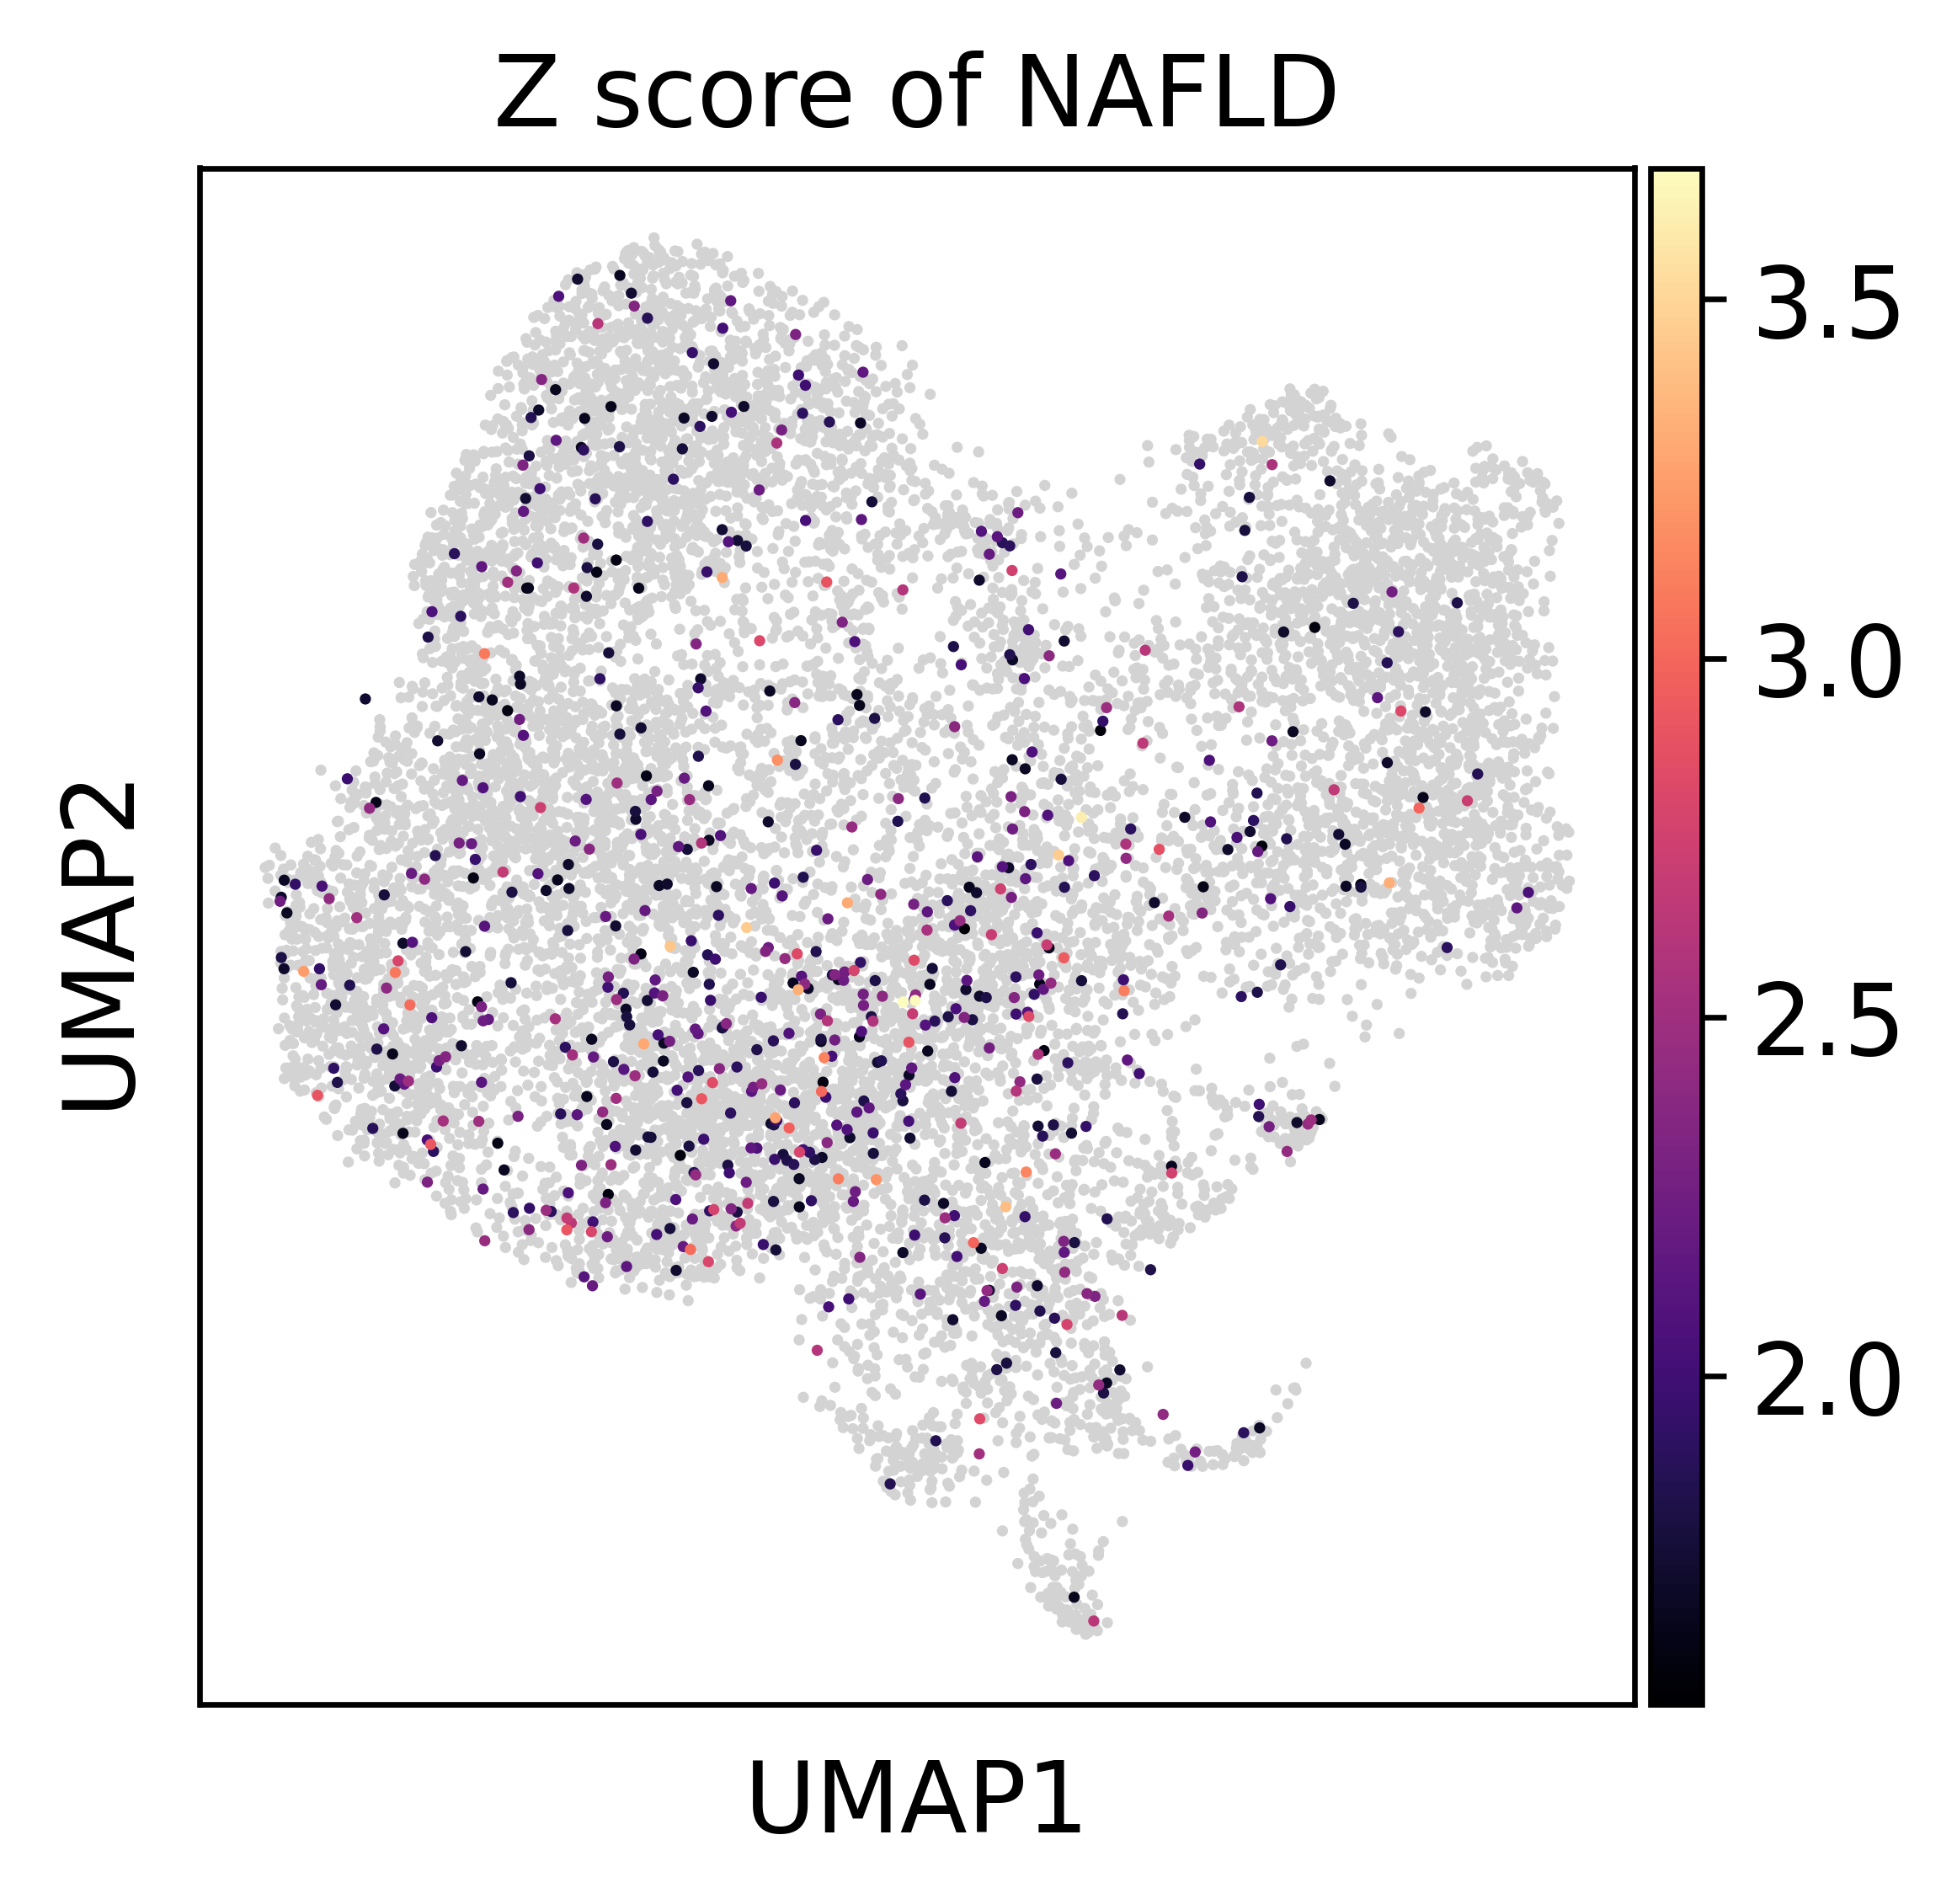

<Figure size 1200x1200 with 0 Axes>

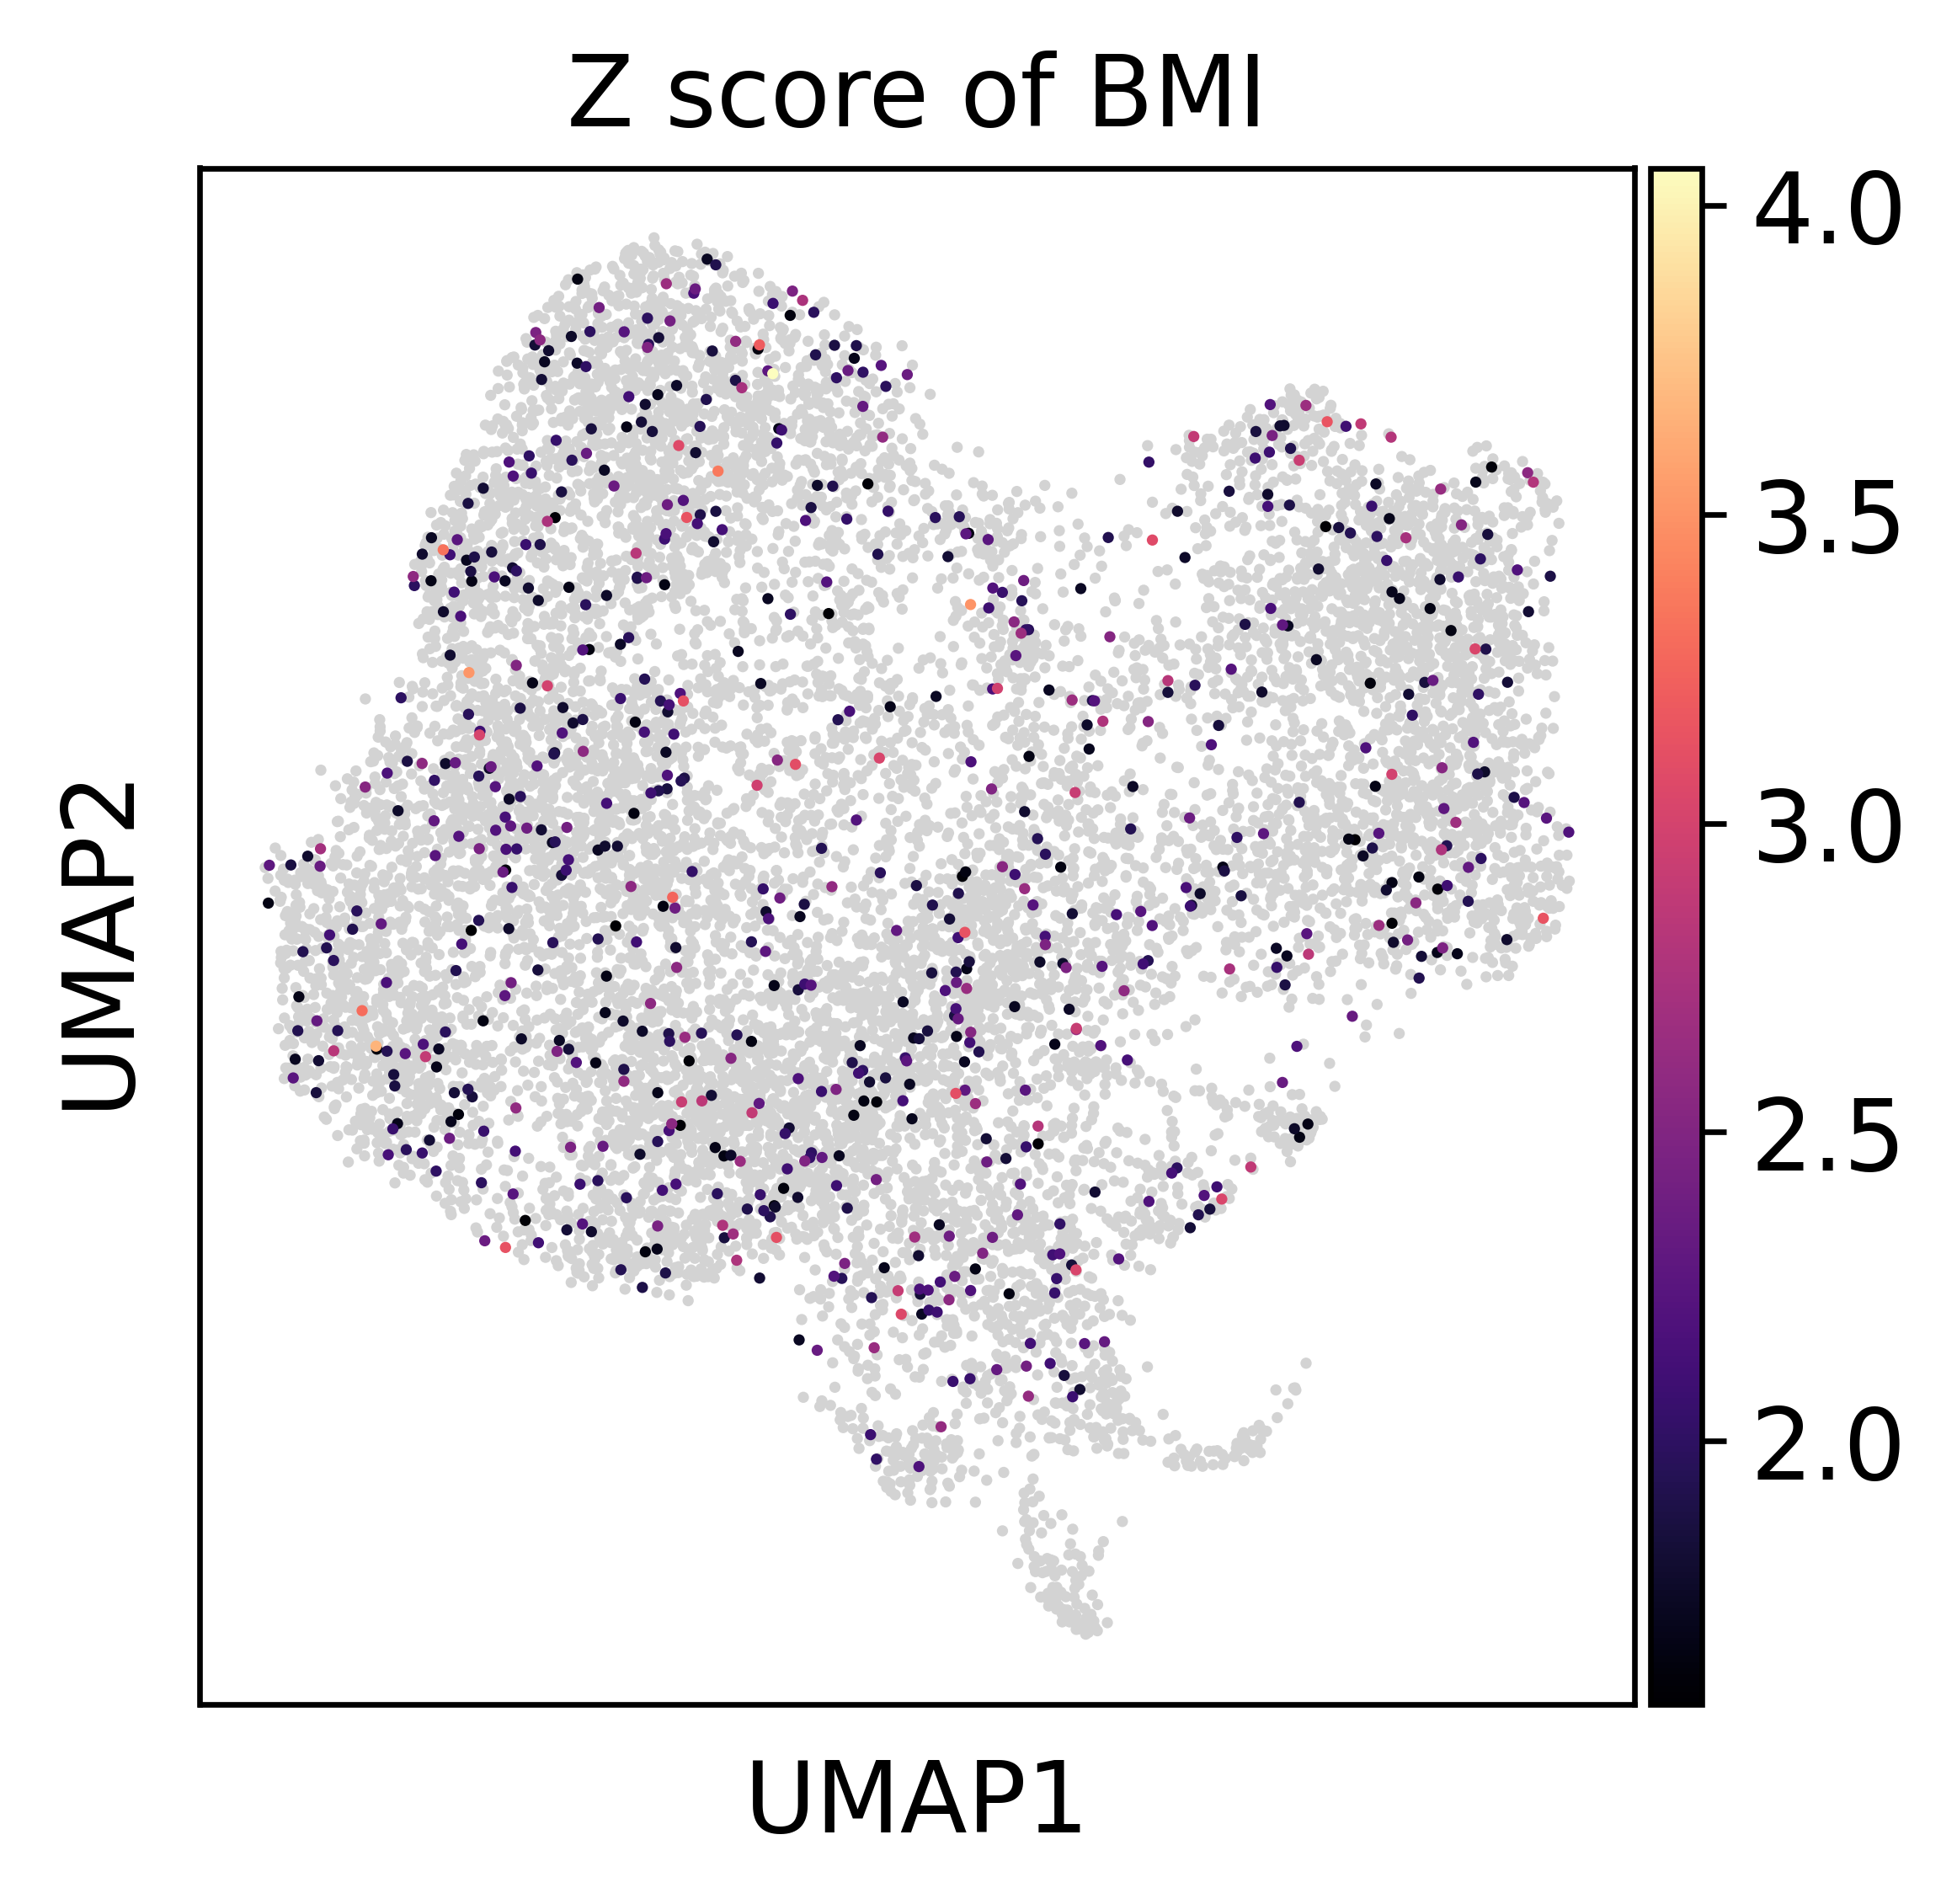

<Figure size 1200x1200 with 0 Axes>

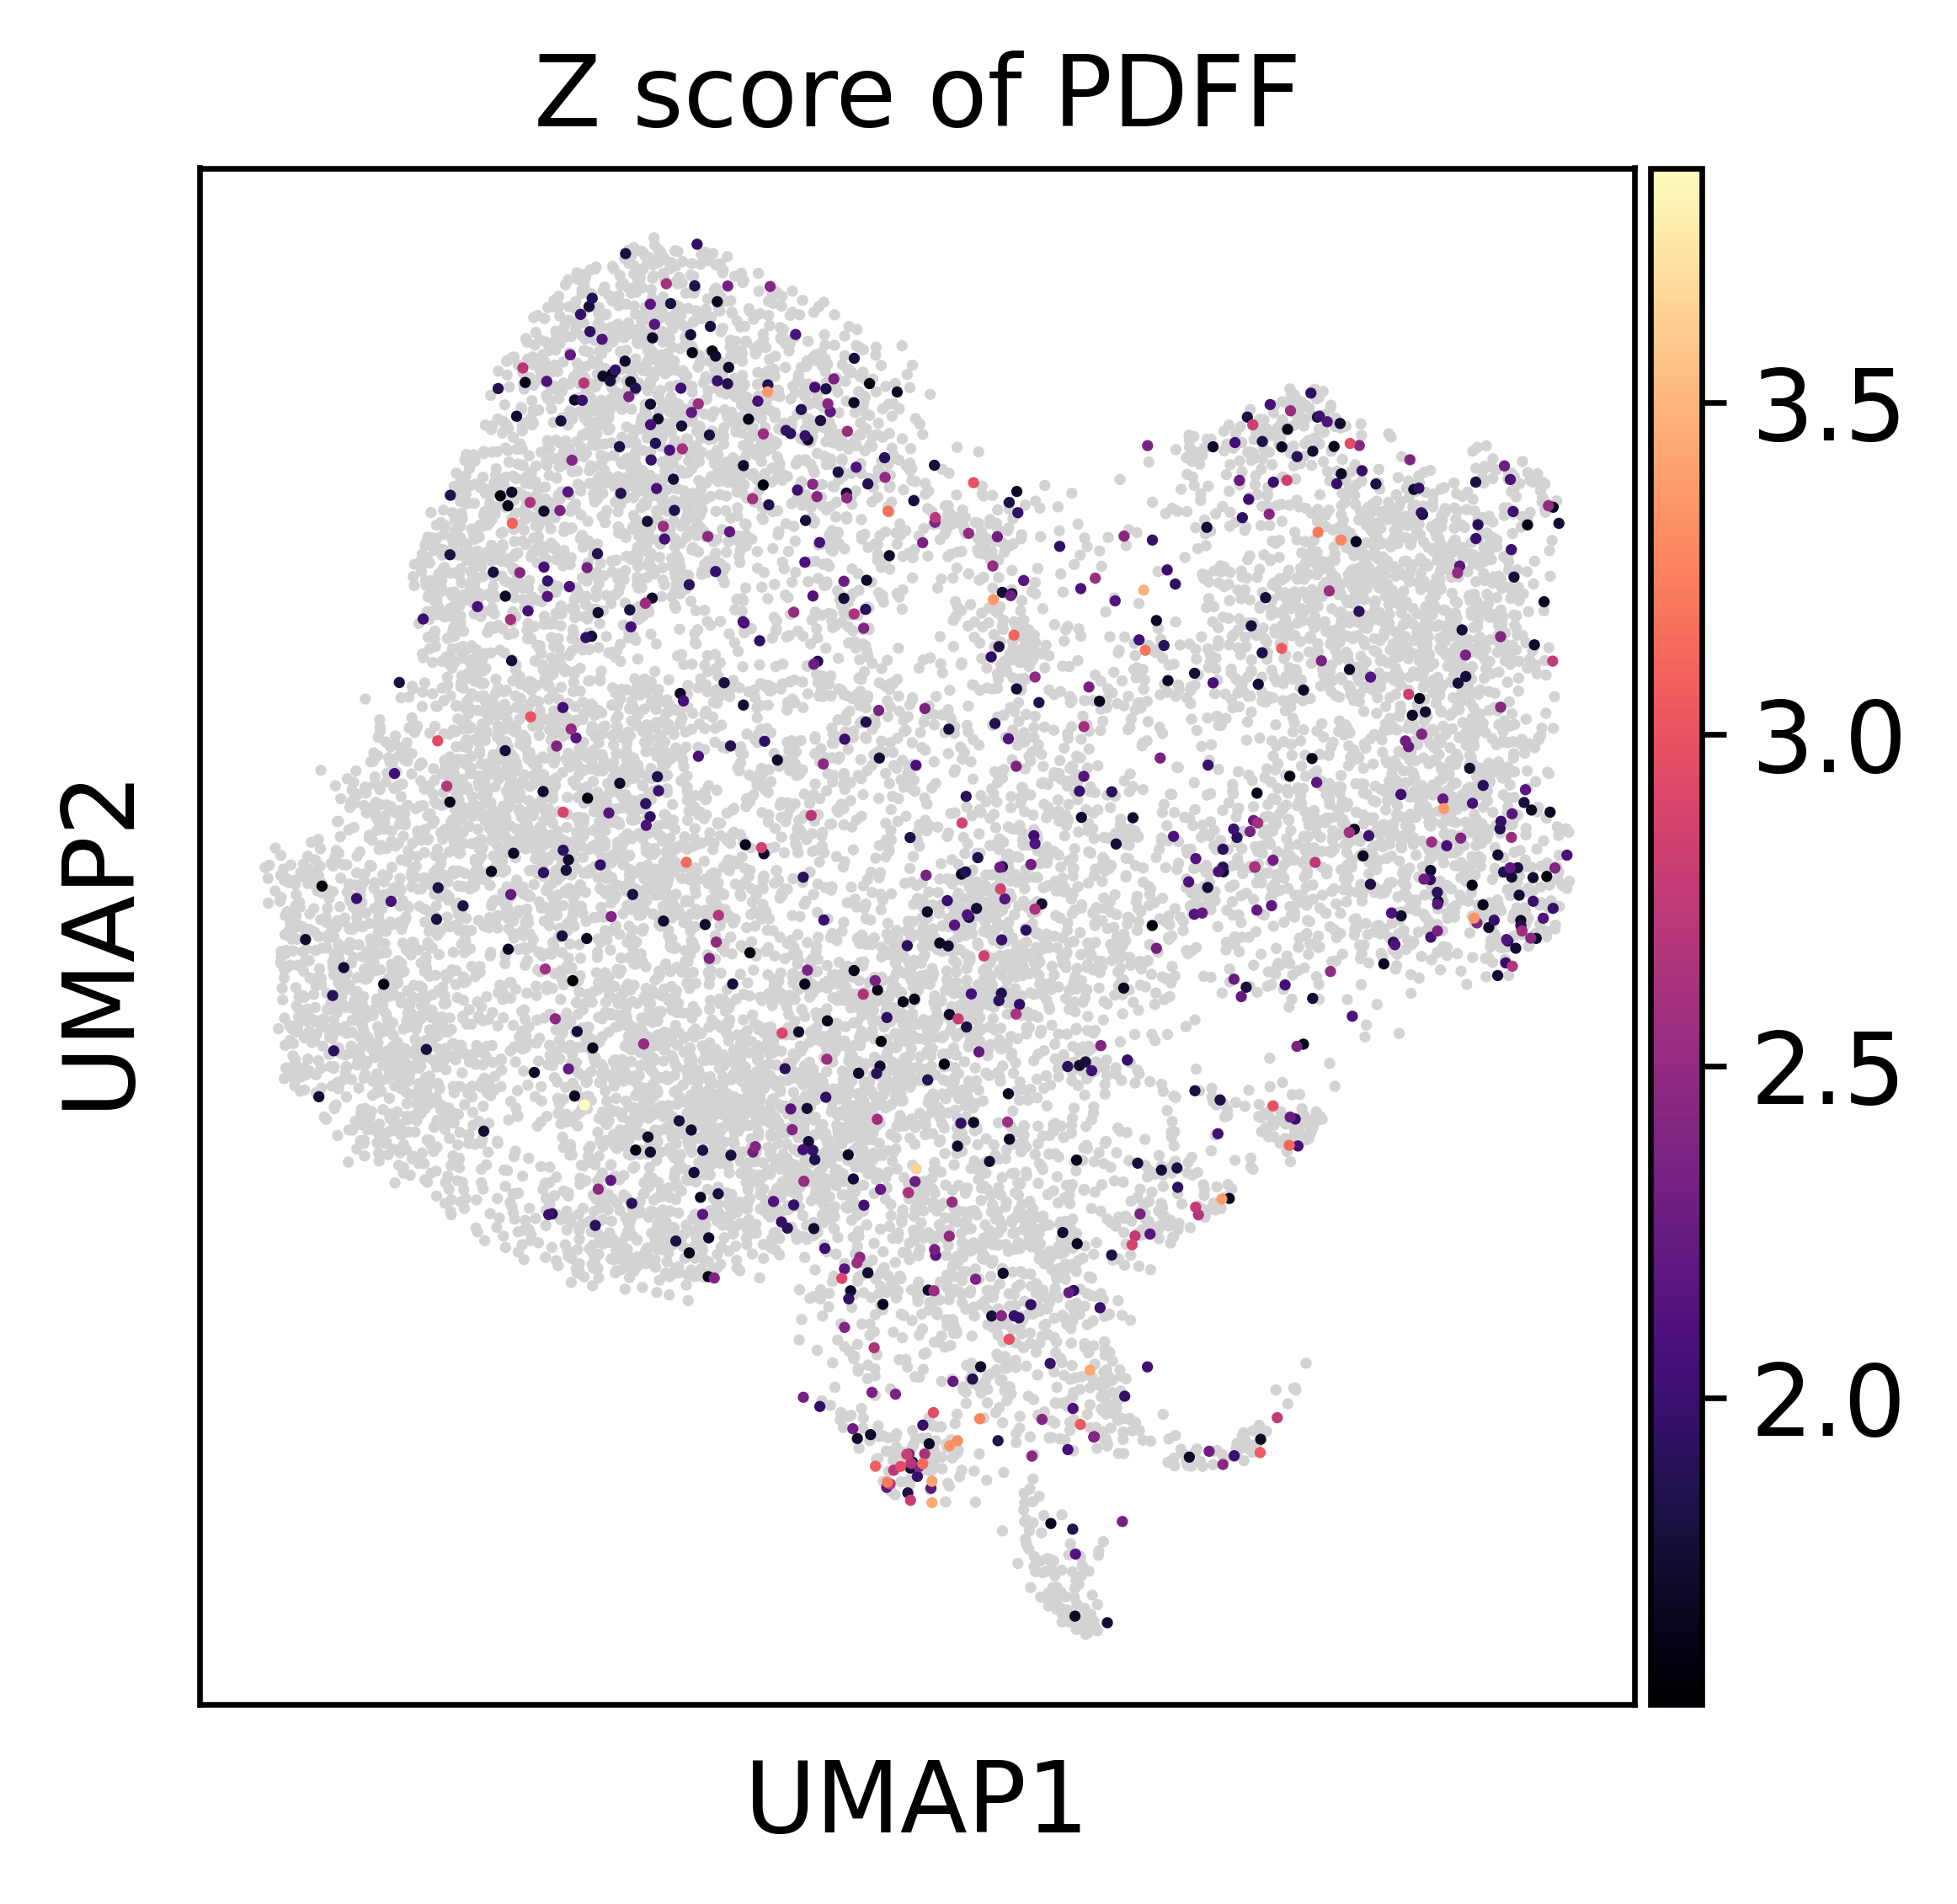

<Figure size 1200x1200 with 0 Axes>

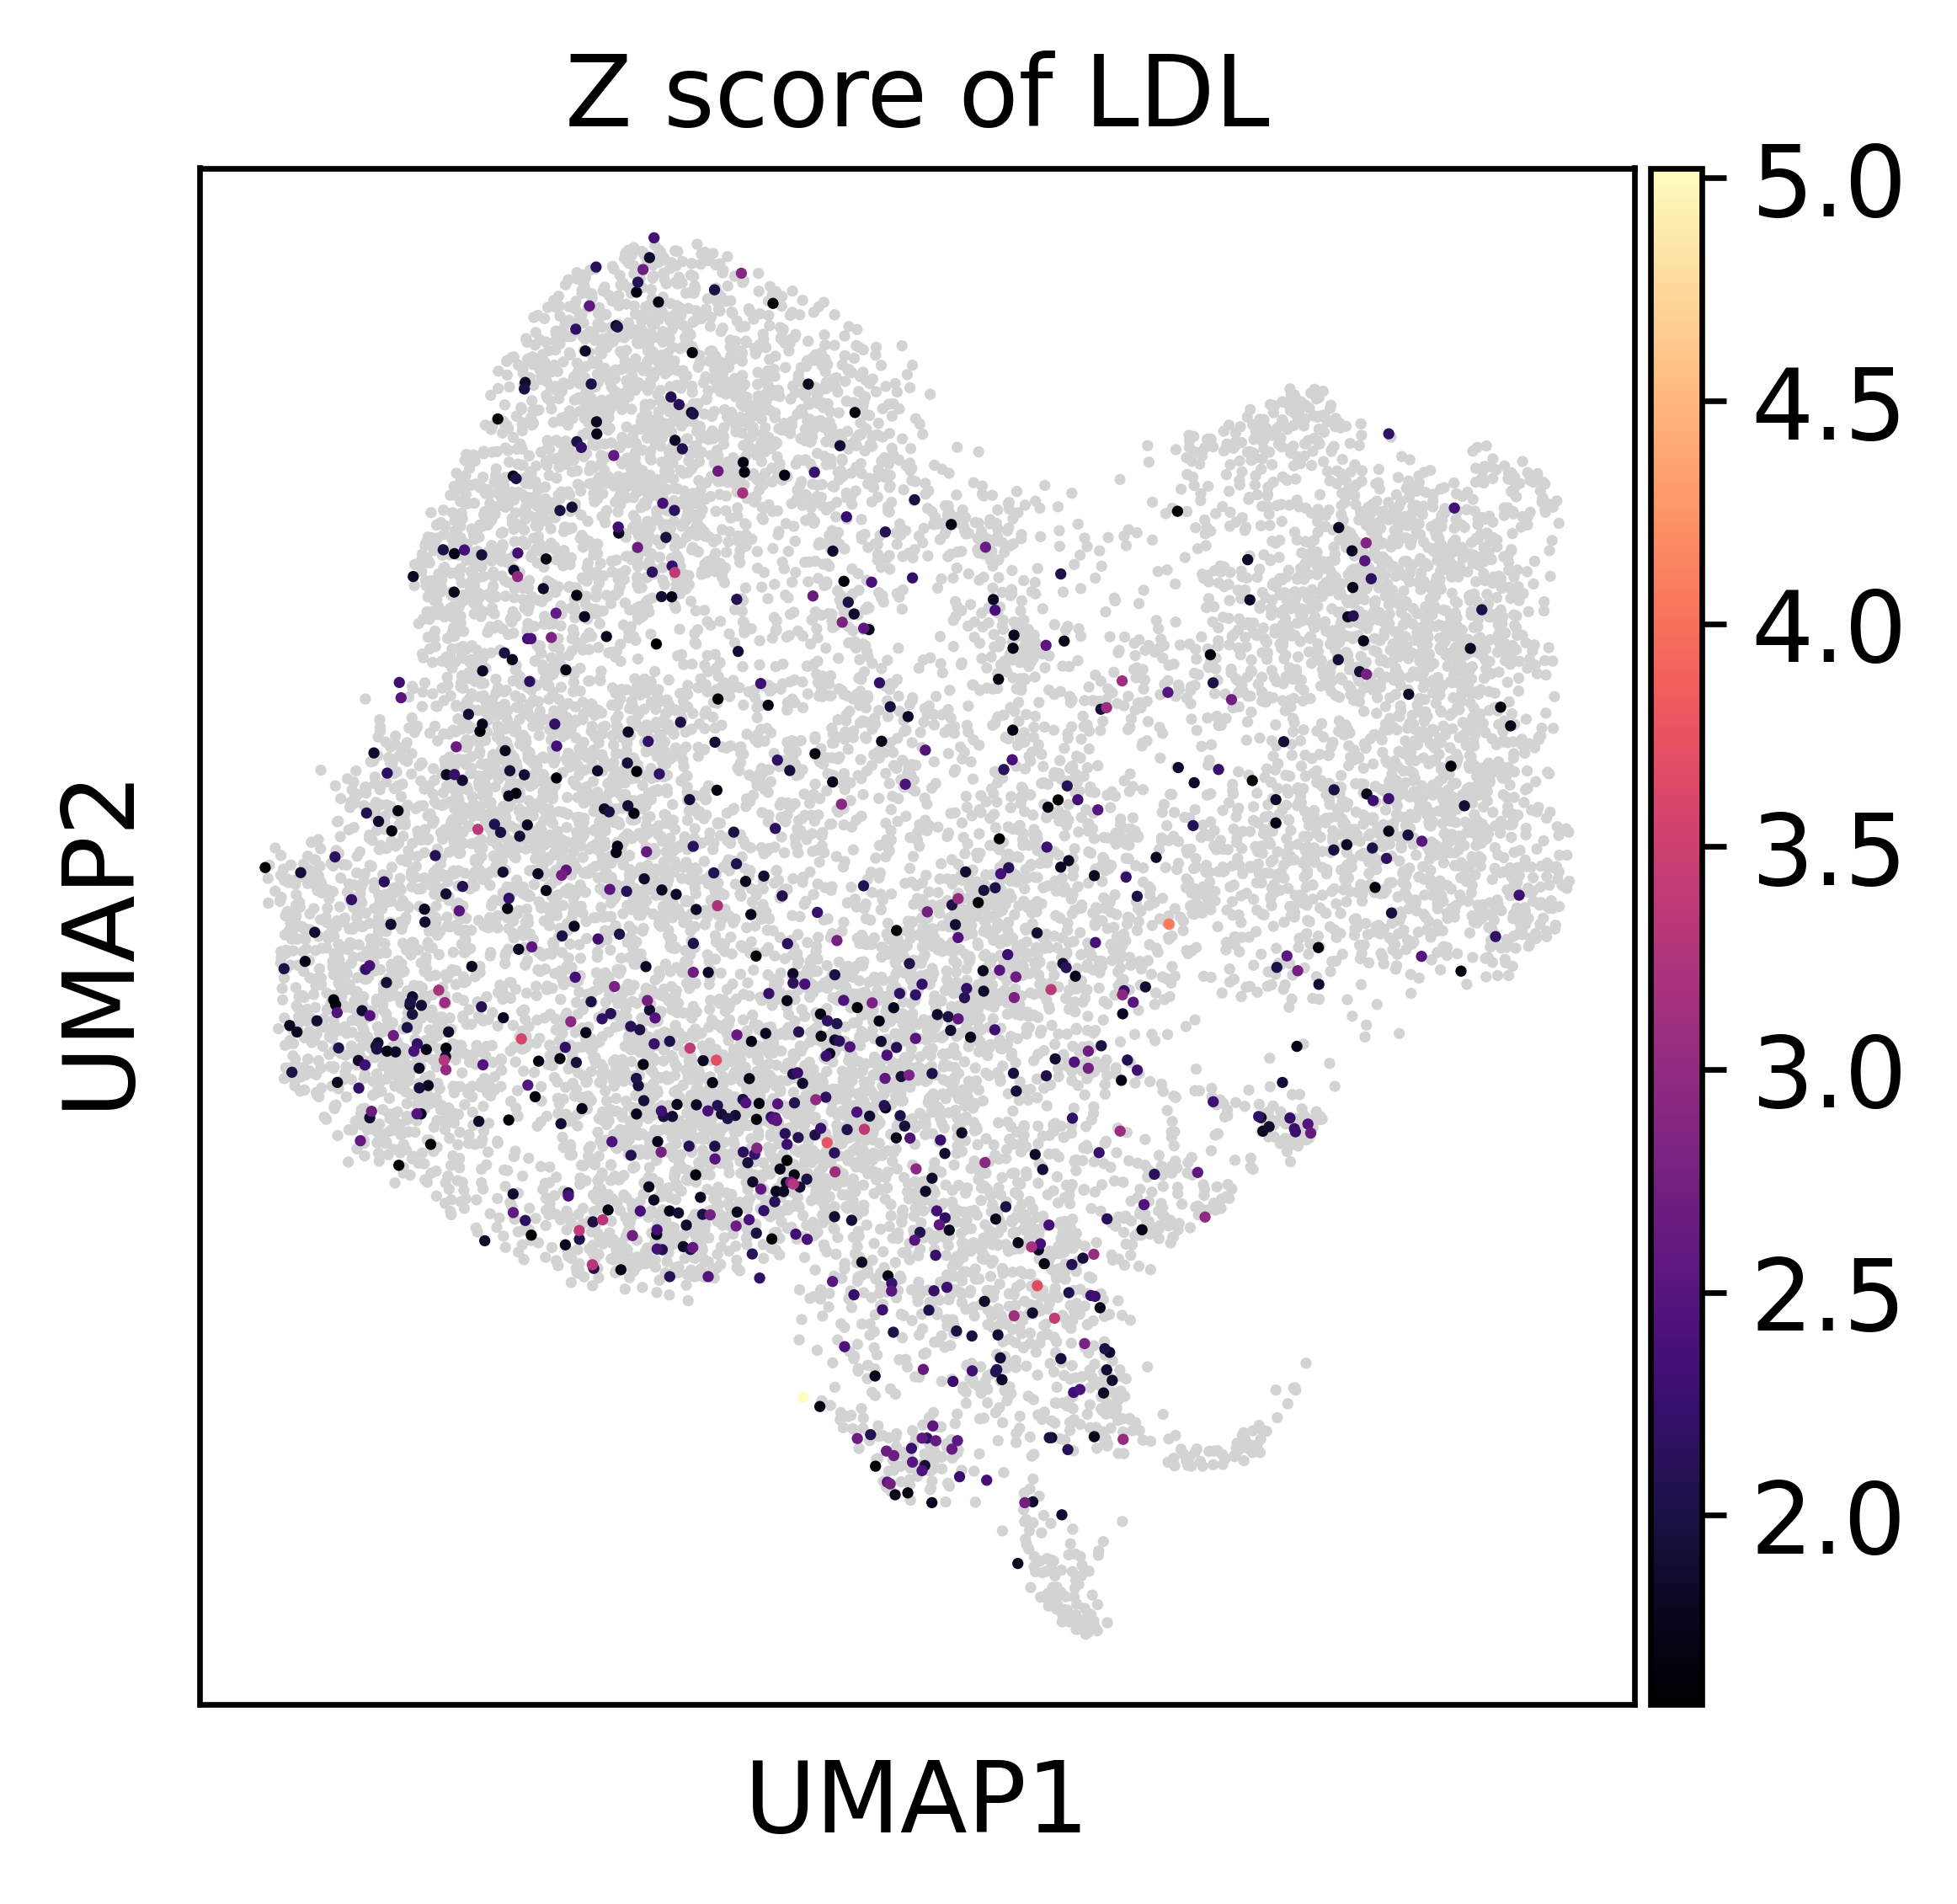

<Figure size 1200x1200 with 0 Axes>

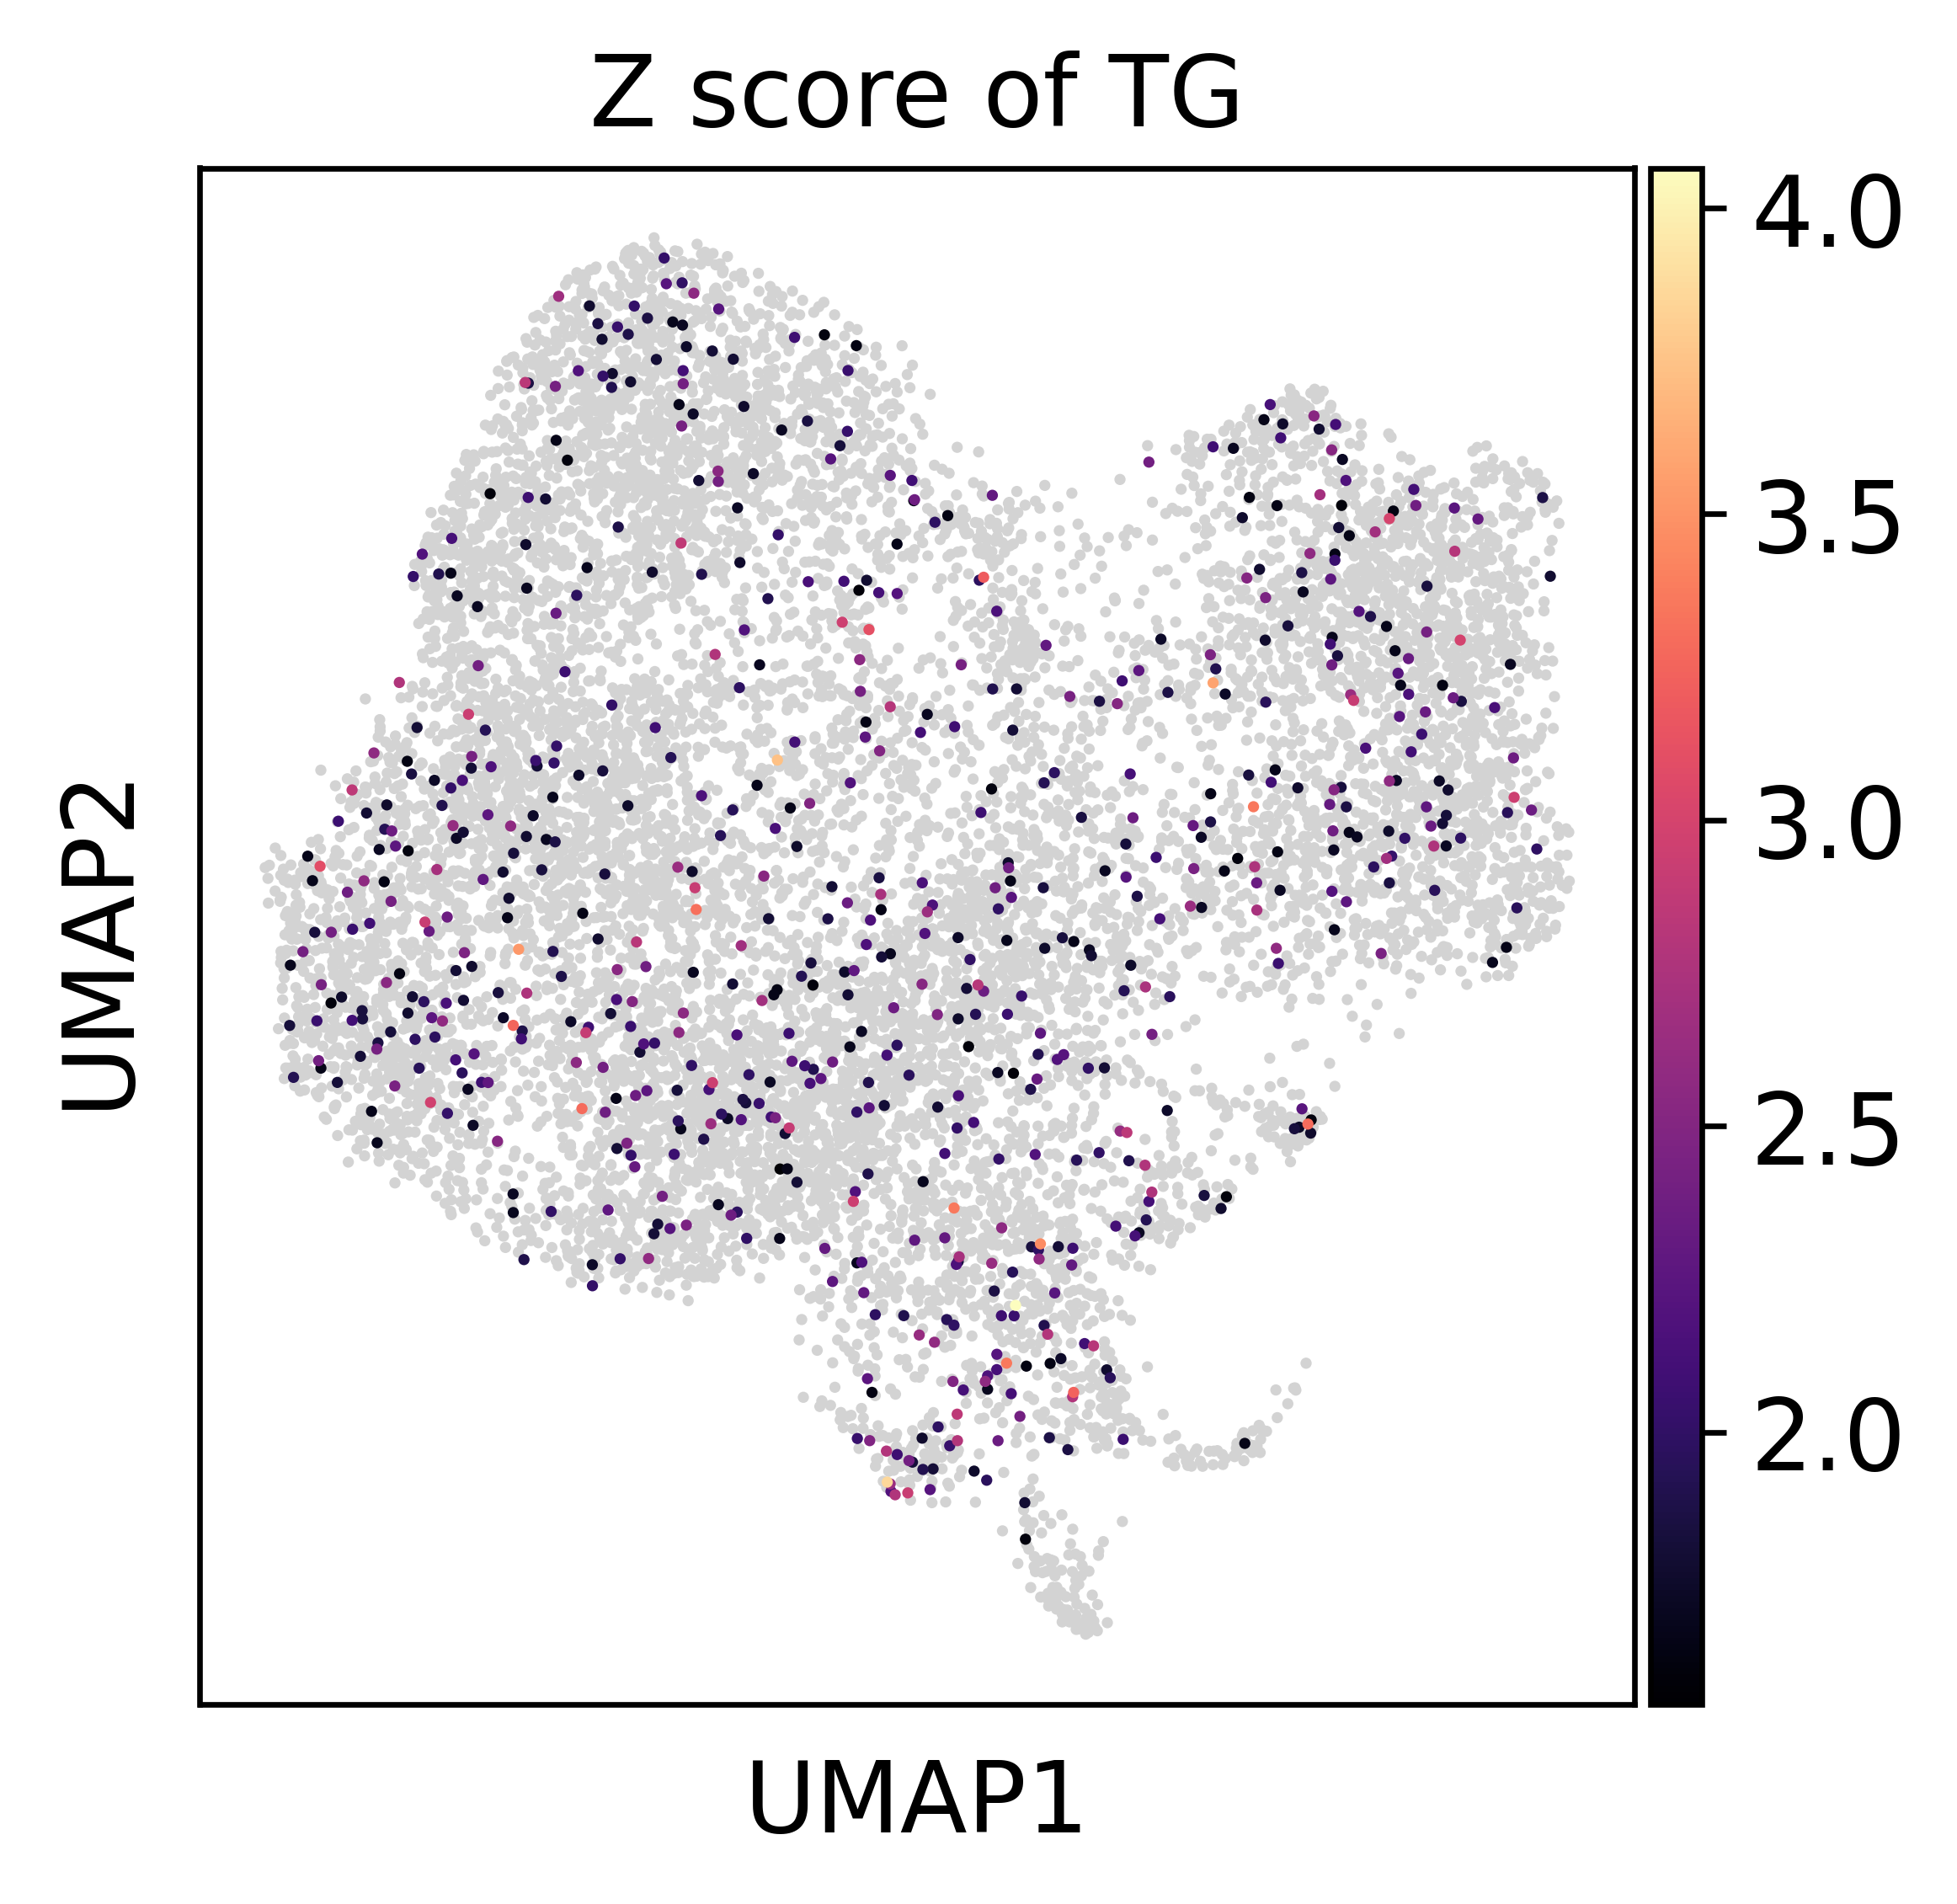

<Figure size 1200x1200 with 0 Axes>

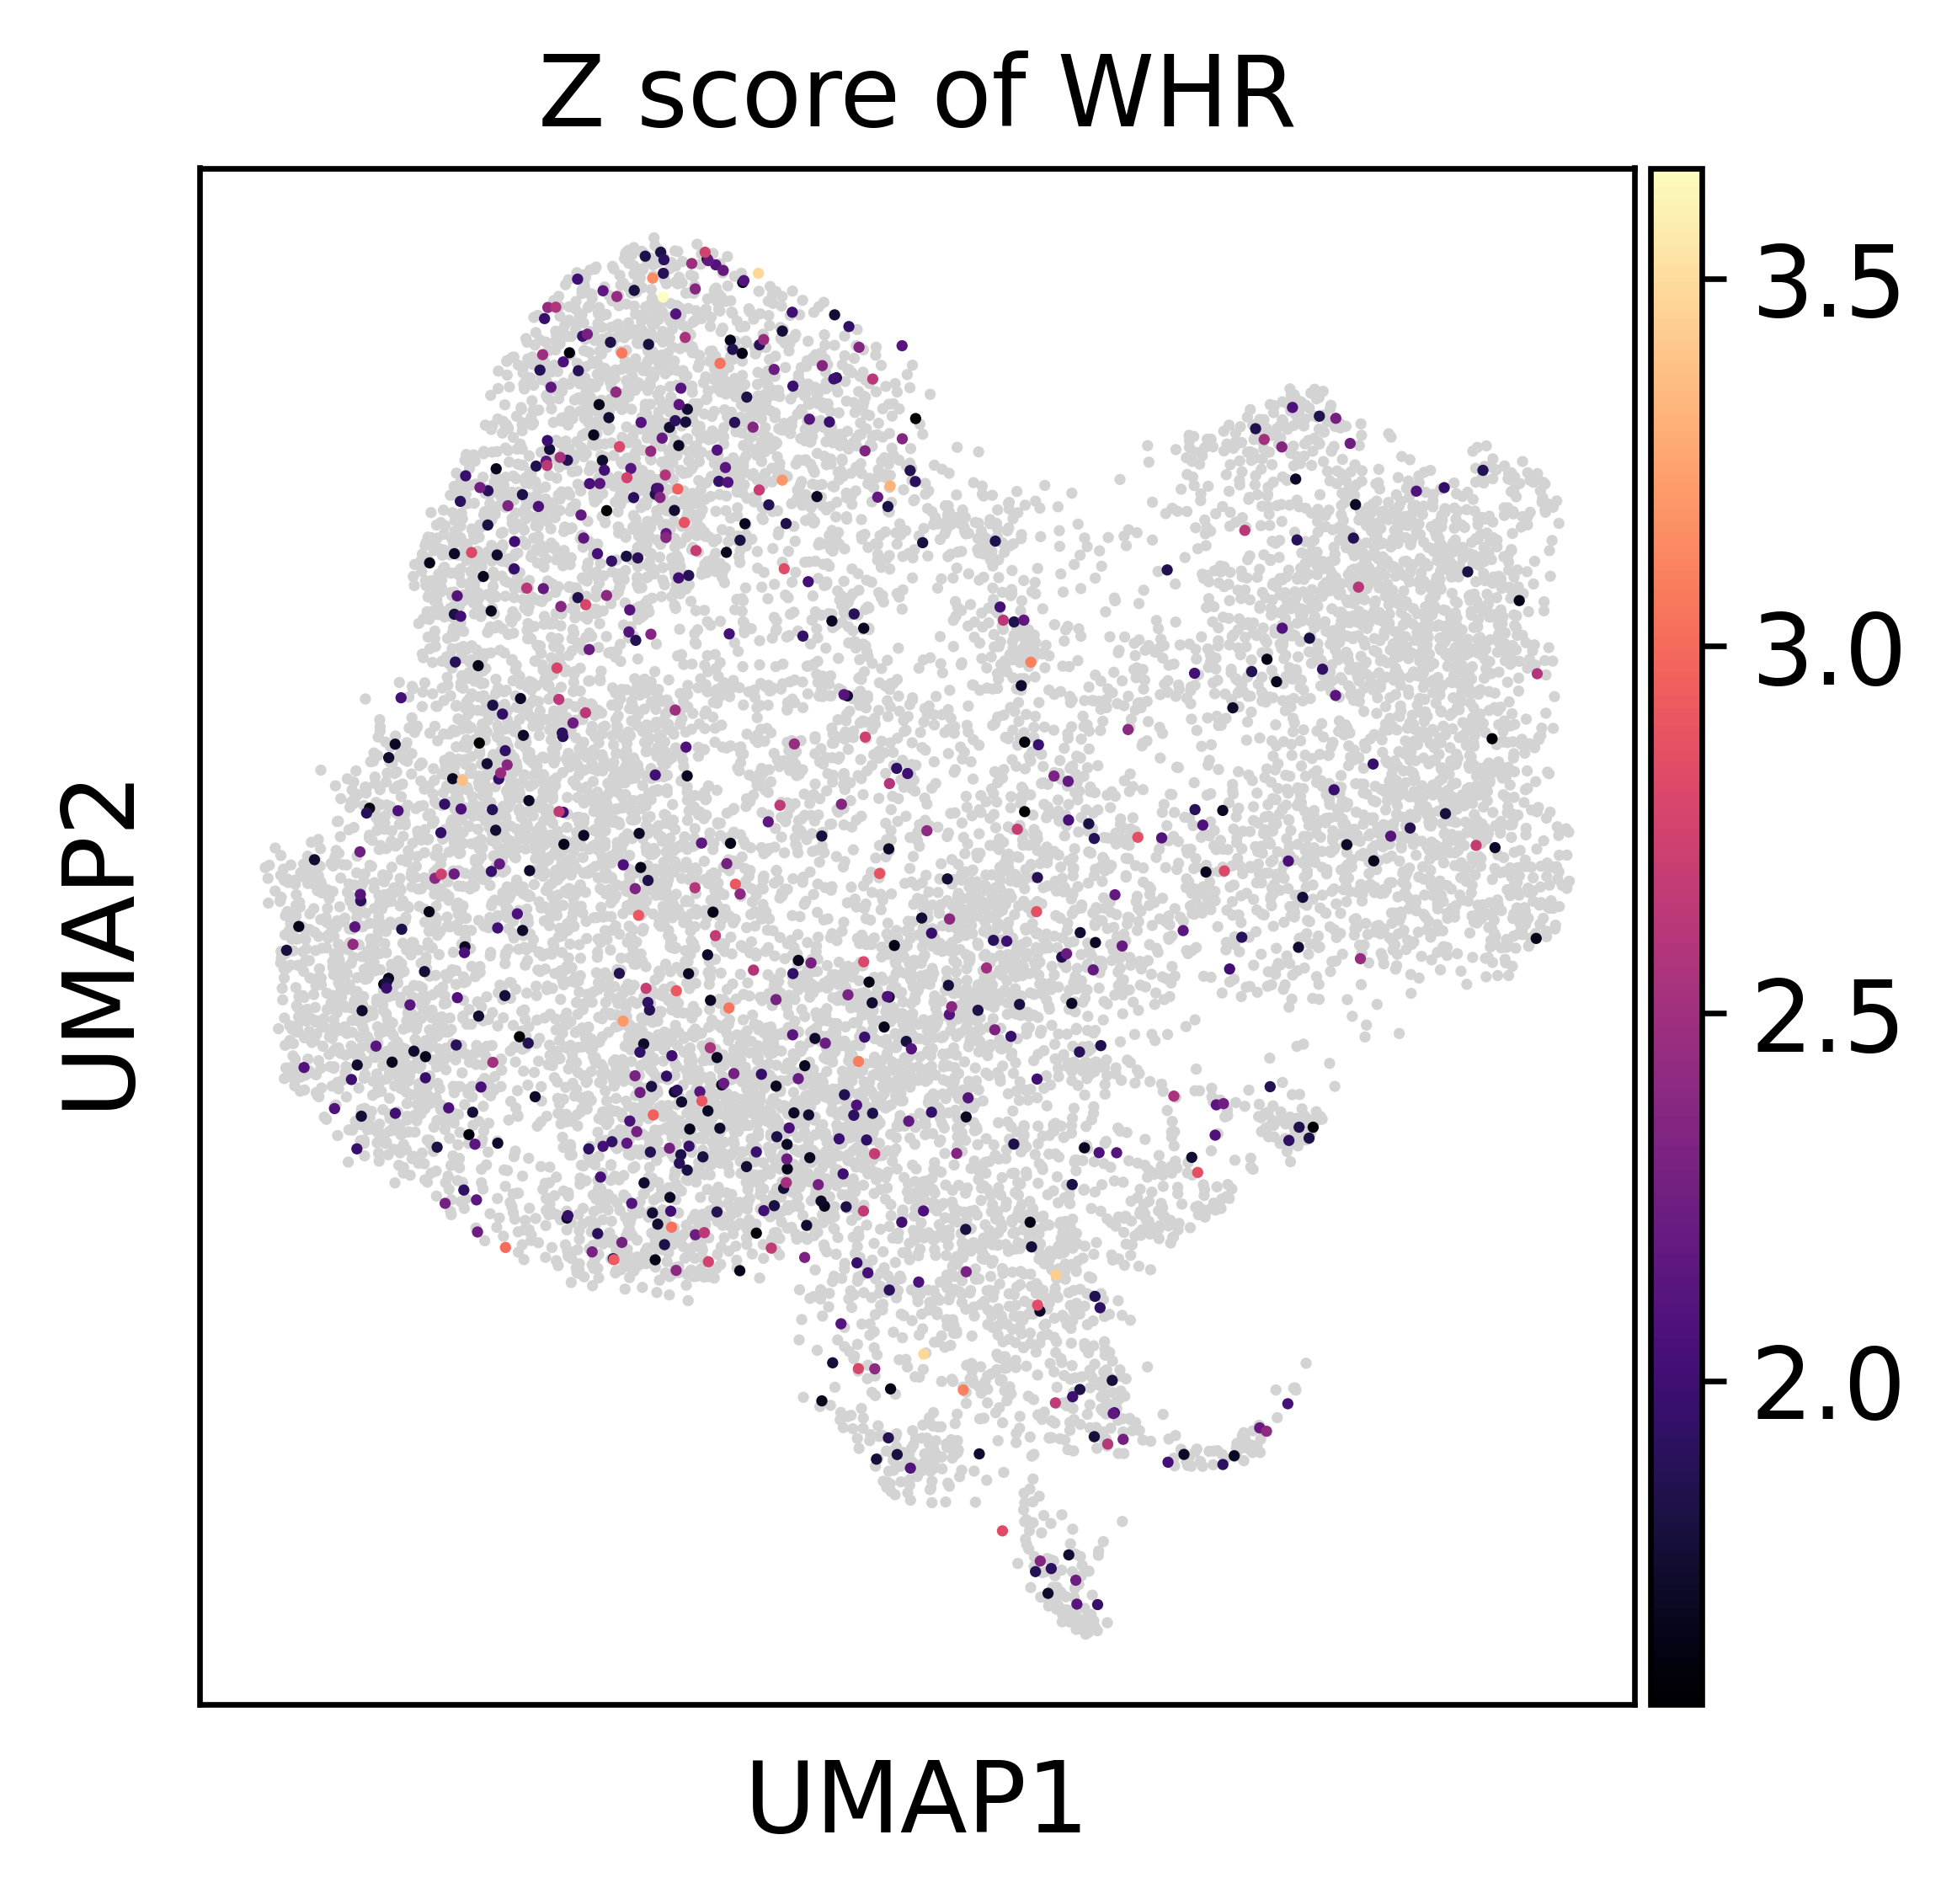

In [18]:
for trait in traits_arr:
    plt.figure(figsize = (4, 4))
    sc.pl.umap(hs_apcs, color = f"{trait}_mask_z", color_map = "magma", show = False)
    plt.title(f"Z score of {trait}")
    plt.savefig(f"./plots/{trait}.pdf")

In [19]:
traits_groupwise_dct = {
    k: pd.read_csv(f"groupwise/{traits_dct[k]}.scdrs_group.cell_lab", sep = '\t', index_col = 0) for k in traits_arr
}

In [20]:
traits_groupwise_dct["NAFLD"]

n_cell  n_ctrl  assoc_mcp  assoc_mcz  hetero_mcp  hetero_mcz  \
group                                                                 
CD142  2953.0  1000.0   0.003996   2.757837    0.024975    2.183346   
CD55   2354.0  1000.0   0.977023  -1.916246    0.025974    2.063531   
CD9    1761.0  1000.0   0.000999   3.880062    0.074925    1.493421   
ICAM1  4692.0  1000.0   0.624376  -0.356942    0.033966    2.000358   

       n_fdr_0.05  n_fdr_0.1  n_fdr_0.2  
group                                    
CD142         0.0        0.0        0.0  
CD55          0.0        0.0        0.0  
CD9           0.0        0.0        0.0  
ICAM1         0.0        0.0        0.0

In [21]:
cell_type_z = pd.concat(
    [
        traits_groupwise_dct[t].loc[cell_arr, "assoc_mcz"].rename(t)
        for t in traits_arr
    ], axis = 1
).T
cell_type_p = pd.concat(
    [
        traits_groupwise_dct[t].loc[cell_arr, "assoc_mcp"].rename(t)
        for t in traits_arr
    ], axis = 1
).T

In [22]:
cell_type_z.to_csv('plots/cell_type_z.csv')

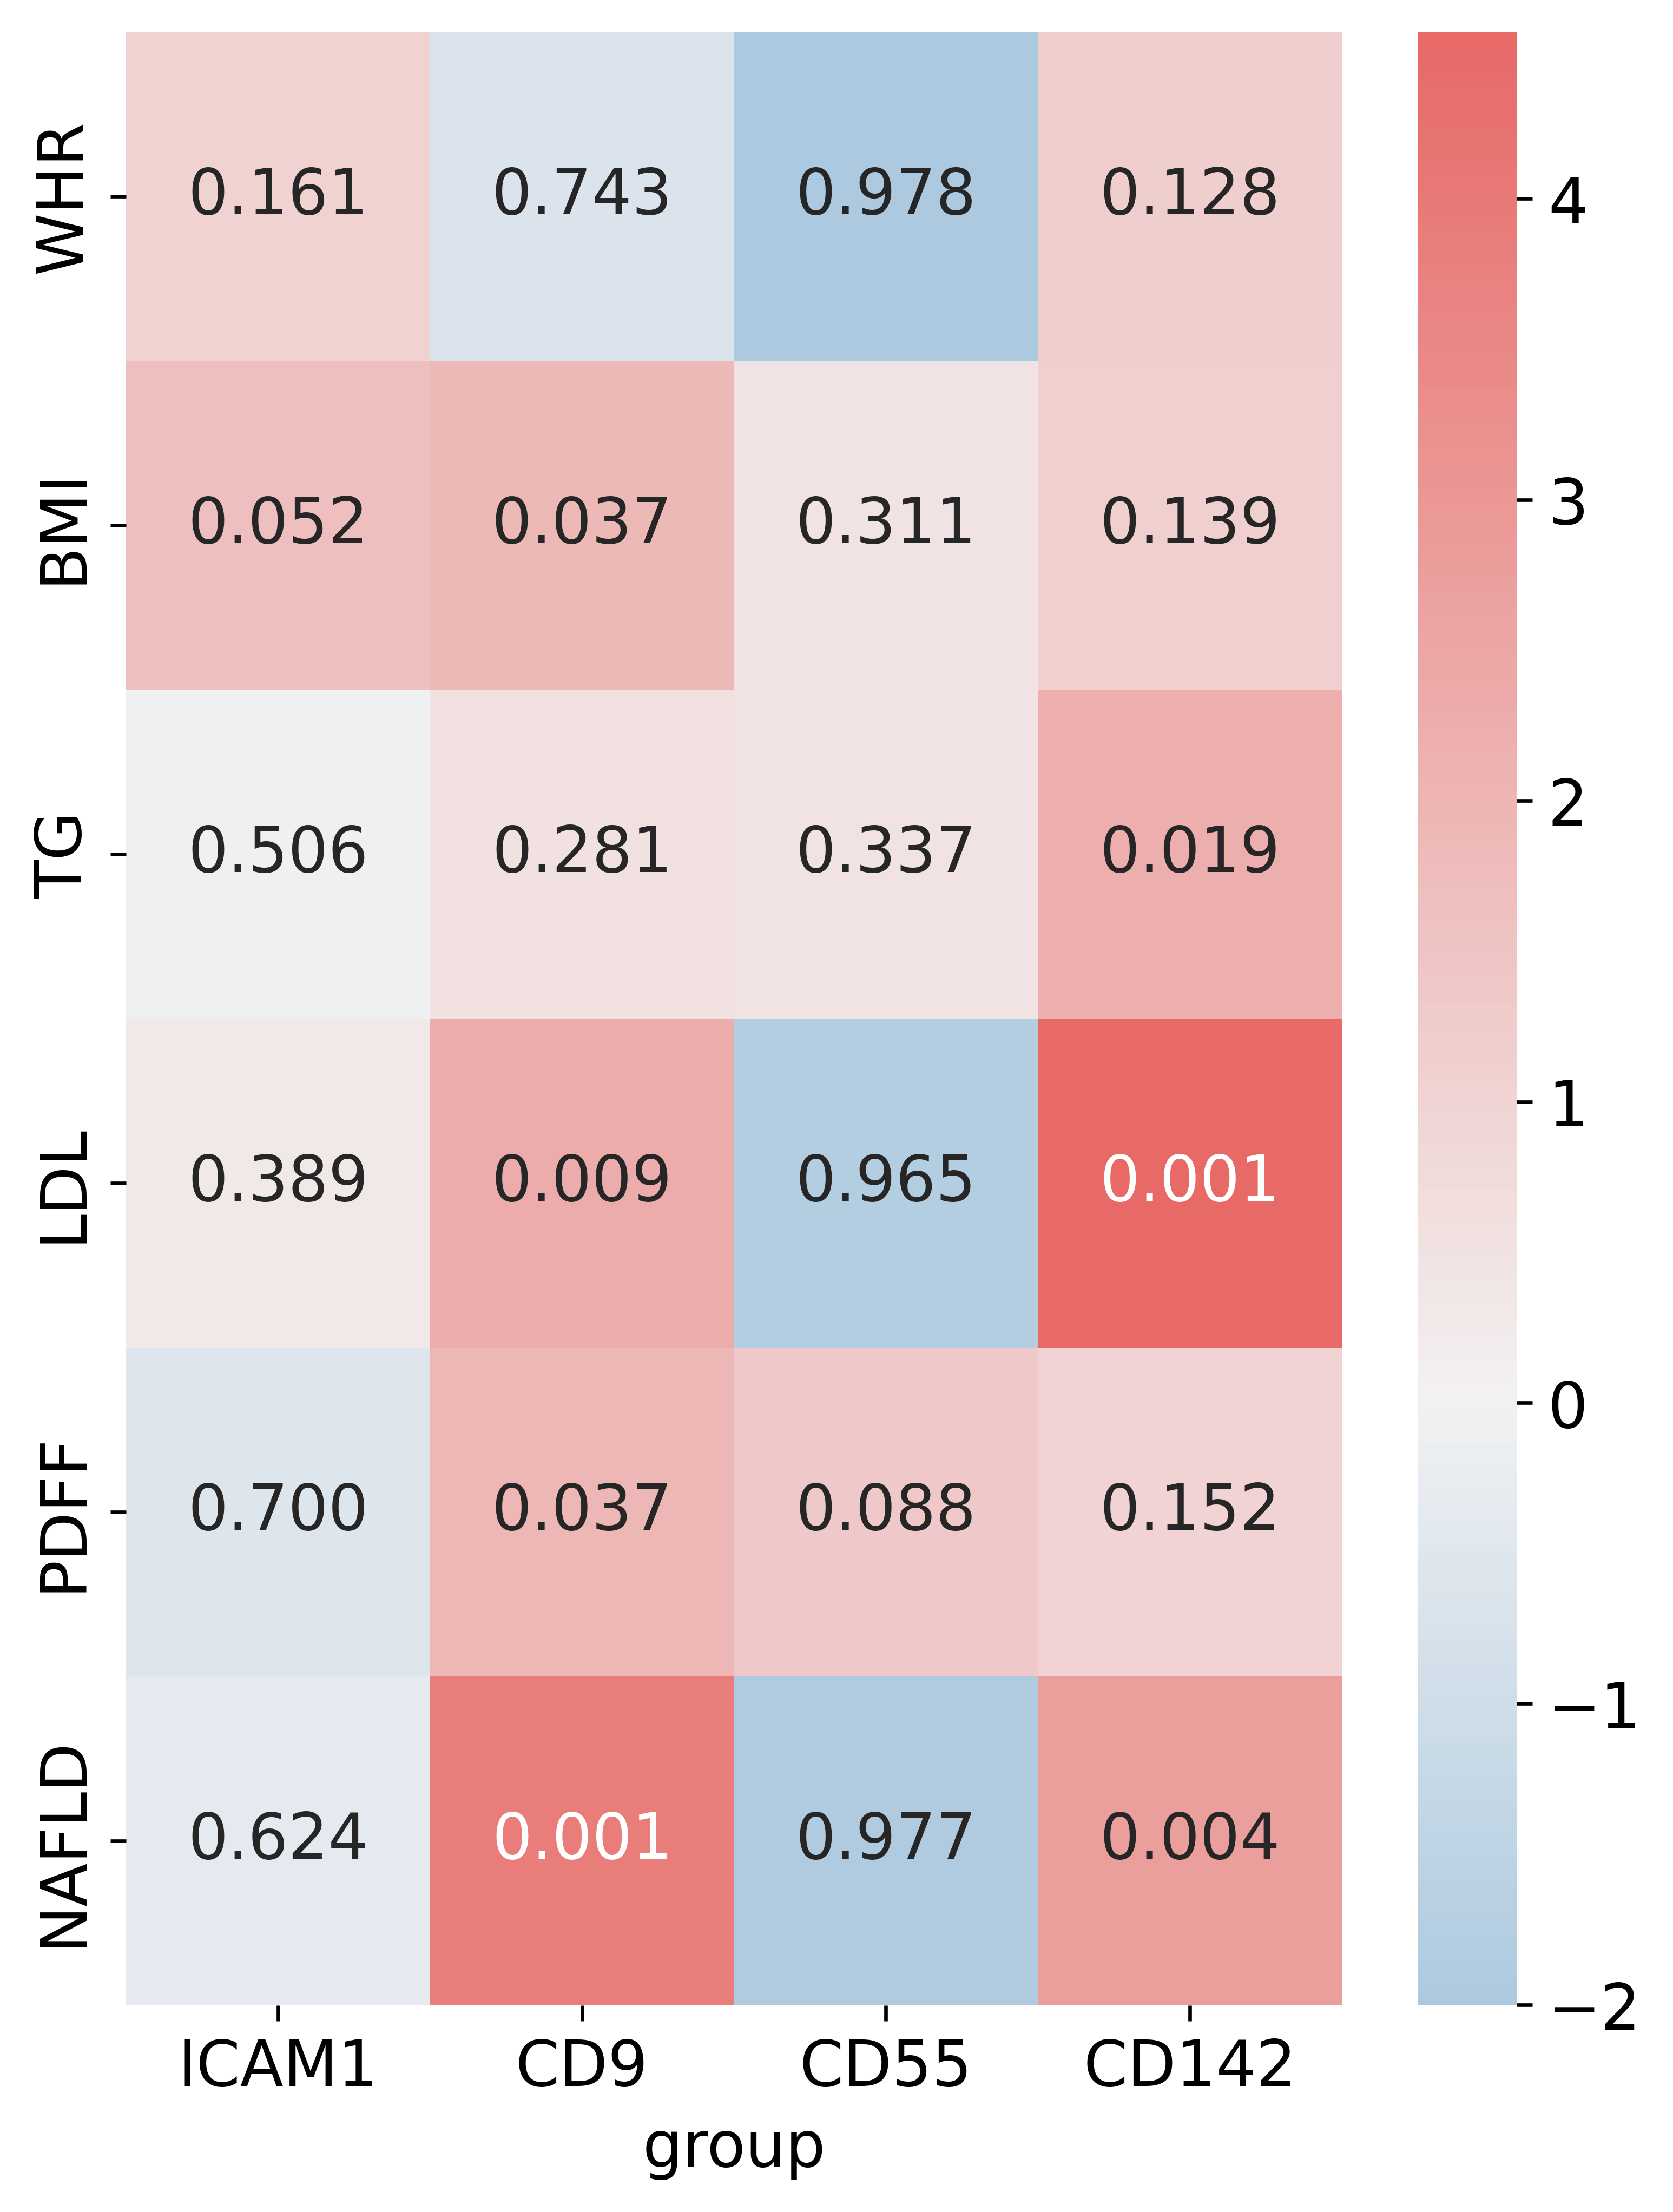

In [49]:
trait_order = ["WHR", "BMI", "TG", "LDL", "PDFF", "NAFLD"]
plt.figure(figsize = (6, 8))
sns.heatmap(
    data = cell_type_z.loc[trait_order, :],
    center = 0,
    annot = cell_type_p.loc[trait_order, :],
    fmt = ".3f",
    cmap = sns.diverging_palette(h_neg = 240, h_pos = 13, s = 70, l = 60, n = 100, as_cmap = True)
)
plt.savefig('plots/heatmap.pdf')